In [1]:
import pytraj as pyt
import pandas as pd
import sys
sys.path.append('../..')

### Reference structure
- Used to load each conformation to perform the alignment before save them to a file.

In [2]:
CRYS_DIR = '../../data/crystal_confs/'
ref_top_path = f'{CRYS_DIR}/pdb_ensemble/1fin_ENS.pdb'
ref_conf = pyt.load(ref_top_path, 
                    ref_top_path)
ref_conf

pytraj.Trajectory, 1 frames: 
Size: 0.000108 (GB)
<Topology: 4848 atoms, 298 residues, 1 mols, non-PBC>
           

### Pocket mask to align the MD structures

In [3]:
from helper_modules.protein_subsequences import get_pocket_residues
# Create the atom selection masks
mask_pkt_Ca = '(:' + get_pocket_residues(sep = ',') + ')&(@CA)'

### DataFrame with the medoids

In [4]:
# Load the dataframe with the selected conformations
proj_type = 'MDconfsOnMDconfs'
selection_mask = 'Pocket'
df_med = pd.read_pickle(f'kMedoid_{proj_type}_{selection_mask}Selection')
traj_groups = df_med.groupby(['Conf.', 'MD-Protocol', 'Rep.'])
traj_keys = list(traj_groups.groups.keys())
df_med

,Conf.,MD-Protocol,Rep.,frame_number,1,2,3,4,5,6,k_label
0,1fin,ETA,1,585,2.488583,-2.494162,13.984608,5.555027,6.154610,8.745882,21.0
1,1fin,ETA,1,770,7.634523,10.886053,26.083253,5.465374,0.130995,4.436915,18.0
2,1fin,ETA,1,1240,-1.287515,-3.692800,15.386576,1.298735,1.125688,6.618417,1.0
3,1fin,ETA,1,1420,-4.748775,9.459986,15.841508,-0.989116,-6.036539,-3.483018,17.0
4,1fin,ETA,1,2045,-6.511891,1.539313,22.652949,6.317480,-9.301950,1.943912,28.0
...,...,...,...,...,...,...,...,...,...,...,...
595,4fku,WAT,3,2500,-13.391900,12.636673,0.393060,2.068754,2.220747,1.210591,23.0
596,4fku,WAT,3,2835,-6.695437,10.207546,-0.139821,-2.424074,5.542192,4.665948,7.0
597,4fku,WAT,3,3100,-8.927276,5.968057,6.094202,-5.723304,7.148031,-6.689246,13.0
598,4fku,WAT,3,3370,1.240873,13.115020,-1.285353,-6.086166,10.419668,4.698858,1.0


### Write medoid MD confs to `PDB` format

In [5]:
# Define input and output folders
OUTPUT_DIR = '../../data/md_medoid_conformations'
MD_DIR  = '../../data/md_trajectories/'
MD_FILE_BASENAME = 'md_imaged_noWAT'

for traj_key in traj_keys:
    # Get the frames of the current rep
    frames   = traj_groups.get_group(traj_key)['frame_number'].to_list()
    pdbid, system, rep = traj_key
    pdb_top_path    = f'{MD_DIR}/{system}_systems/rep_{rep}/' +\
                      f'{pdbid}/md/{MD_FILE_BASENAME}.pdb'
    pdbid_traj_path = f'{MD_DIR}/{system}_systems/rep_{rep}/' + \
                      f'{pdbid}/md/{MD_FILE_BASENAME}.trr'
    # Load the trajectory
    traj = pyt.load(pdbid_traj_path, 
                    top = pdb_top_path, 
                    frame_indices = frames)
    if system == 'LIG':
        traj = traj['!:LIG'] # Remove `:LIG` residue, if present
    # Align the traj to the reference structure
    traj = pyt.align(traj, ref = ref_conf)
    for i, frame in enumerate(frames):
        # Create the output name
        output_file = f'{OUTPUT_DIR}/{proj_type}/' +\
                      f'{pdbid}-{system}-rep{rep}-frame{frame}.pdb'
        pyt.write_traj(filename = output_file, 
                       traj = traj[i:i+1])

## Visualize the saved structures

In [15]:
saved_frames = list(df_med[['Conf.', 'MD-Protocol', 
                     'Rep.', 'frame_number']]\
                    .itertuples(index=False, name=None))
saved_frames_files =  [f'{OUTPUT_DIR}/{proj_type}/' +\
     f'{pdbid}-{system}-rep{rep}-frame{frame}.pdb' 
        for pdbid, system, rep, frame in saved_frames
    ]

meds_traj = pyt.load(saved_frames_files, top = ref_top_path)

In [16]:
import nglview as nv
nv.show_pytraj(meds_traj)

NGLWidget(max_frame=599)

In [93]:
## Projection using the fitted PCA model
import joblib
from pca_helpers import get_coords

pca_pkt_MDonMD = joblib.load(f'./pca_{proj_type}_{selection_mask}Selection.joblib')
# Use the fitted pca to project the saved conformations

traj_coords = get_coords()

PCA(n_components=10)

## RMDS against reference structure
- Compute the RMSD of the saved structures using `1fin` as the reference

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'ticks', context = 'talk', font_scale = 0.8)

In [47]:
type_confs_names  = ['inact_src', 'active', 'inact_ope', 'dfg_out']
pdbid_confTypes   = {'1fin': 'active', '4fku': 'inact_src', 
                       '3pxf': 'inact_ope', '5a14': 'dfg_out'}
ref_confs_colors  = ['#3DB8C1', '#EB5F5F',  '#FAB332', '#B389FA']
conf_label_colors = dict(zip(pdbid_confTypes.keys(), ref_confs_colors))

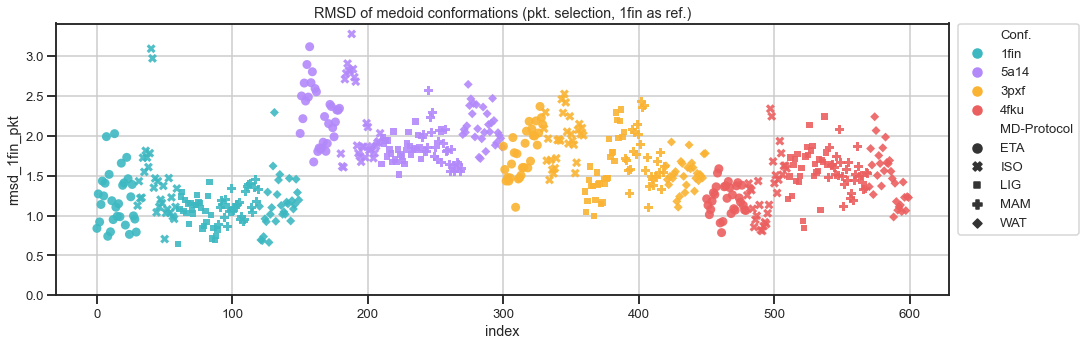

In [53]:
rmsd_pkt = pyt.rmsd(meds_traj, mask = mask_pkt_Ca, ref = ref_conf)
df_med['rmsd_1fin_pkt'] = rmsd_pkt 

fig, ax = plt.subplots(figsize = (16, 5))
sns.scatterplot(data = df_med.reset_index(), 
                x = 'index', y = 'rmsd_1fin_pkt',
                linewidth = 0, alpha = 0.9,
                palette = conf_label_colors,
                style = 'MD-Protocol',
                hue = 'Conf.')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.title('RMSD of medoid conformations (pkt. selection, 1fin as ref.)')
plt.ylim(0)
plt.grid()
plt.show()

## RMSD matrix

In [21]:
rmsd_mtx = pyt.pairwise_rmsd(meds_traj, mask = mask_pkt_Ca)

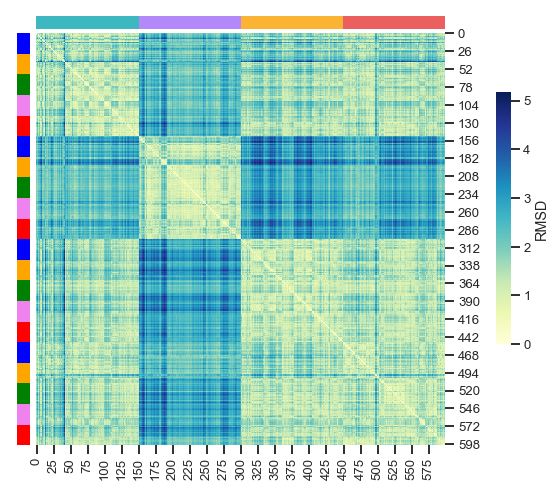

In [83]:

init_conf_cols = df_med['Conf.'].replace(conf_label_colors).to_numpy()
md_protocol_cols = df_med['MD-Protocol'].replace({'WAT': 'red', 'LIG': 'green',
                        'ETA': 'blue', 'ISO': 'orange', 
                        'MAM': 'violet'}).to_numpy()
sns.clustermap(rmsd_mtx, 
               cmap = 'YlGnBu',
                col_cluster = False, row_cluster = False,
                col_colors = init_conf_cols, 
                row_colors = md_protocol_cols,
                cbar_pos = (1, 0.3, 0.03, 0.5), 
                dendrogram_ratio = (0.01, 0.01),
                cbar_kws={'label': 'RMSD'},
                figsize = (7, 7))

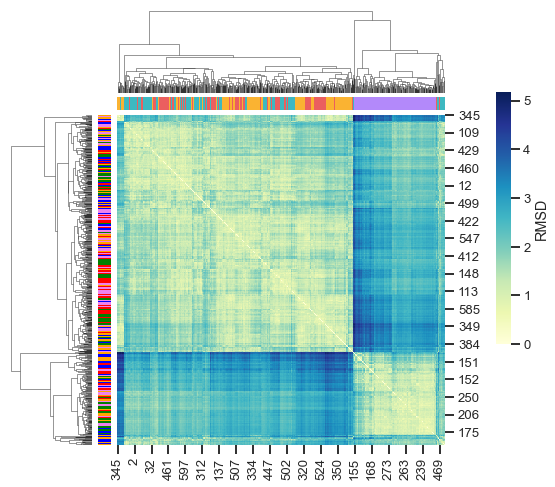

In [89]:
sns.clustermap(rmsd_mtx, 
               cmap = 'YlGnBu',
                col_cluster = True, row_cluster = True,
                col_colors = init_conf_cols, 
                row_colors = md_protocol_cols,
                cbar_pos = (1, 0.3, 0.03, 0.5), 
                dendrogram_ratio = (0.2, 0.2),
                cbar_kws={'label': 'RMSD'},
                figsize = (7, 7))

## Classical Multidimensional Scaling